In [ ]:
import pandas as pd

# Load the CSVs
icsa = pd.read_csv("ICSA.csv", parse_dates=["observation_date"], index_col="observation_date")
t10y3m = pd.read_csv("T10Y3M-2.csv", parse_dates=["observation_date"], index_col="observation_date")
indpro = pd.read_csv("INDPRO.csv", parse_dates=["observation_date"], index_col="observation_date")
payems = pd.read_csv("PAYEMS.csv", parse_dates=["observation_date"], index_col="observation_date")
unrate = pd.read_csv("UNRATE.csv", parse_dates=["observation_date"], index_col="observation_date")
umcsent = pd.read_csv("UMCSENT.csv", parse_dates=["observation_date"], index_col="observation_date")
usrec = pd.read_csv("USREC.csv", parse_dates=["observation_date"], index_col="observation_date")

#end of month to ensure consistent alignment
icsa.index = icsa.index.to_period("M").to_timestamp("M")
t10y3m.index = t10y3m.index.to_period("M").to_timestamp("M")
indpro.index = indpro.index.to_period("M").to_timestamp("M")
payems.index = payems.index.to_period("M").to_timestamp("M")
unrate.index = unrate.index.to_period("M").to_timestamp("M")
umcsent.index = umcsent.index.to_period("M").to_timestamp("M")
usrec.index = usrec.index.to_period("M").to_timestamp("M")

# Resample non-monthly series (weekly/daily) to monthly
icsa = icsa.resample("M").last()
t10y3m = t10y3m.resample("M").last()


icsa.columns = ['ICSA']
t10y3m.columns = ['T10Y3M']
indpro.columns = ['INDPRO']
payems.columns = ['PAYEMS']
unrate.columns = ['UNRATE']
umcsent.columns = ['UMCSENT']
usrec.columns = ['USREC']

# Merge all data into one DataFrame and drop rows with any missing values
df = pd.concat([t10y3m, icsa, indpro, payems, unrate, umcsent, usrec], axis=1).dropna()

print(df.head())


                  T10Y3M      ICSA   INDPRO    PAYEMS  UNRATE  UMCSENT  USREC
observation_date                                                             
2000-01-31          0.92  285000.0  91.4092  131011.0     4.0    112.0      0
2000-02-29          0.64  280000.0  91.7245  131121.0     4.1    111.3      0
2000-03-31          0.15  272000.0  92.0830  131604.0     4.0    107.1      0
2000-04-30          0.41  291000.0  92.6659  131883.0     3.8    109.2      0
2000-05-31          0.66  280000.0  92.9347  132105.0     4.0    110.7      0


/var/folders/zp/9mxpv2kn4tgd0903pfg2lb2r0000gn/T/ipykernel_11738/3268268535.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  icsa = icsa.resample("M").last()
/var/folders/zp/9mxpv2kn4tgd0903pfg2lb2r0000gn/T/ipykernel_11738/3268268535.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  t10y3m = t10y3m.resample("M").last()


In [6]:

pd.set_option('display.max_rows', None)


print(df)


                  T10Y3M       ICSA    INDPRO    PAYEMS  UNRATE  UMCSENT  \
observation_date                                                           
2000-01-31          0.92   285000.0   91.4092  131011.0     4.0    112.0   
2000-02-29          0.64   280000.0   91.7245  131121.0     4.1    111.3   
2000-03-31          0.15   272000.0   92.0830  131604.0     4.0    107.1   
2000-04-30          0.41   291000.0   92.6659  131883.0     3.8    109.2   
2000-05-31          0.66   280000.0   92.9347  132105.0     4.0    110.7   
2000-06-30          0.15   296000.0   93.0018  132062.0     4.0    106.4   
2000-07-31         -0.23   298000.0   92.8373  132228.0     4.0    108.3   
2000-08-31         -0.58   312000.0   92.5910  132234.0     4.1    107.3   
2000-09-30         -0.43   292000.0   92.9827  132338.0     3.9    106.8   
2000-10-31         -0.61   301000.0   92.6400  132352.0     3.9    105.8   
2000-11-30         -0.73   356000.0   92.6604  132556.0     3.9    107.6   
2000-12-31  

In [19]:
# Merge all data into one DataFrame
df = pd.concat([t10y3m, icsa, indpro, payems, unrate, umcsent, usrec], axis=1).dropna()

# Cut off data at December 2020 due to COVID-19 spikes
df = df.loc[df.index <= '2020-12-31']

print(df.head())


                  T10Y3M      ICSA   INDPRO    PAYEMS  UNRATE  UMCSENT  USREC
observation_date                                                             
2000-01-31          0.92  285000.0  91.4092  131011.0     4.0    112.0      0
2000-02-29          0.64  280000.0  91.7245  131121.0     4.1    111.3      0
2000-03-31          0.15  272000.0  92.0830  131604.0     4.0    107.1      0
2000-04-30          0.41  291000.0  92.6659  131883.0     3.8    109.2      0
2000-05-31          0.66  280000.0  92.9347  132105.0     4.0    110.7      0


In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Use the truncated data up to 2020-12-31
df_cutoff = df.loc[df.index <= '2020-12-31']

# First difference the unemployment rate
unrate_diff_cut = df_cutoff['UNRATE'].diff().dropna()

# Split into training and testing sets (80/20 split without COVID variable)
split_index = int(len(unrate_diff_cut) * 0.8)
train_y = unrate_diff_cut.iloc[:split_index]
test_y = unrate_diff_cut.iloc[split_index:]

# Fit ARIMA model
model = ARIMA(train_y, order=(1, 0, 1))
model_fit = model.fit()

# Forecast for the test set length
forecast_diff = model_fit.forecast(steps=len(test_y))

# Evaluate performance
rmse = mean_squared_error(test_y, forecast_diff, squared=False)
r2 = r2_score(test_y, forecast_diff)


forecast_df_diff = pd.DataFrame({
    'Actual_diff_UNRATE': test_y,
    'Forecast_diff_UNRATE': forecast_diff
})

rmse, r2, forecast_df_diff.head()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(1.5460353098200341,
 -0.0003951537892010748,
             Actual_diff_UNRATE  Forecast_diff_UNRATE
 2016-10-31                -0.1              0.013158
 2016-11-30                -0.2              0.012689
 2016-12-31                 0.0              0.012249
 2017-01-31                 0.0              0.011836
 2017-02-28                -0.1              0.011449)

In [15]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


df_cutoff = df.loc[df.index <= '2020-12-31']

#First-difference the UNRATE series
unrate_diff = df_cutoff['UNRATE'].diff().dropna()

#Train-test split (80% train, 20% test)
split_index = int(len(unrate_diff) * 0.8)
train_series = unrate_diff.iloc[:split_index]
test_series = unrate_diff.iloc[split_index:]

#Fit auto_arima on training set
model_auto_diff = pm.auto_arima(train_series,
                                seasonal=False,
                                stepwise=True,
                                suppress_warnings=True,
                                error_action='ignore')

#Forecast over test period
forecast_diff = model_auto_diff.predict(n_periods=len(test_series))

#Evaluate performance
rmse = mean_squared_error(test_series, forecast_diff, squared=False)
r2 = r2_score(test_series, forecast_diff)

#Combine actual and forecasted differenced values
forecast_df_diff = pd.DataFrame({
    'Actual_diff_UNRATE': test_series,
    'Forecast_diff_UNRATE': forecast_diff
})

rmse, r2, forecast_df_diff.head()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(1.5457920781355496,
 -8.040204199866174e-05,
             Actual_diff_UNRATE  Forecast_diff_UNRATE
 2016-10-31                -0.1              0.000463
 2016-11-30                -0.2              0.017112
 2016-12-31                 0.0              0.017112
 2017-01-31                 0.0              0.017112
 2017-02-28                -0.1              0.017112)

In [22]:
# Add lagged versions of UNRATE to the DataFrame
df['UNRATE_lag1'] = df['UNRATE'].shift(1)
df['UNRATE_lag2'] = df['UNRATE'].shift(2)
df['UNRATE_lag3'] = df['UNRATE'].shift(3)

# Drop rows with NaN due to lagging
df_lagged = df.dropna()

# Define new feature matrix including lags
X_lagged = df_lagged.drop(columns=['UNRATE'])
y_lagged = df_lagged['UNRATE']

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train_lagged, X_test_lagged, y_train_lagged, y_test_lagged = train_test_split(
    X_lagged, y_lagged, test_size=0.2, random_state=42)

# Train Random Forest with lagged features
from sklearn.ensemble import RandomForestRegressor
rf_lagged = RandomForestRegressor(n_estimators=100, random_state=42)
rf_lagged.fit(X_train_lagged, y_train_lagged)

# Predict and evaluate
y_pred_lagged = rf_lagged.predict(X_test_lagged)
from sklearn.metrics import mean_squared_error, r2_score
rmse_lagged = mean_squared_error(y_test_lagged, y_pred_lagged, squared=False)
r2_lagged = r2_score(y_test_lagged, y_pred_lagged)

# Create result preview
rf_lagged_results = pd.DataFrame({
    'Actual_UNRATE': y_test_lagged,
    'Predicted_UNRATE': y_pred_lagged
}).reset_index(drop=True)

rmse_lagged, r2_lagged, rf_lagged_results.head()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.4293710283659118,
 0.9382338917180378,
    Actual_UNRATE  Predicted_UNRATE
 0            9.0             8.874
 1            3.9             3.969
 2            5.4             5.054
 3            5.2             5.165
 4            9.6             9.537)

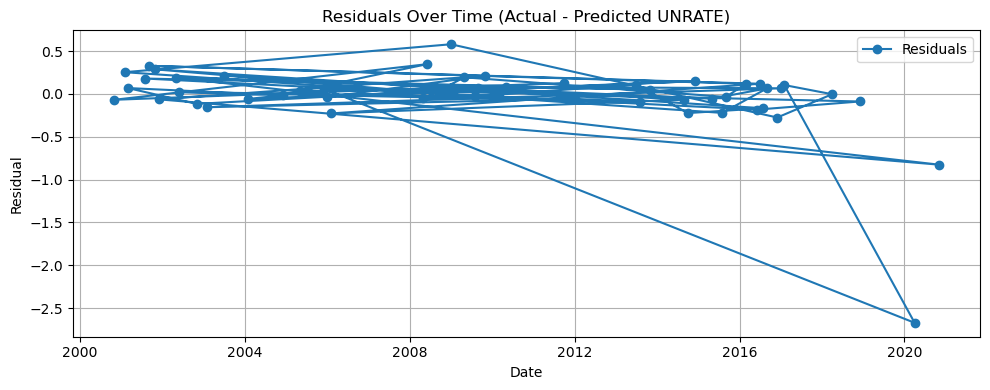

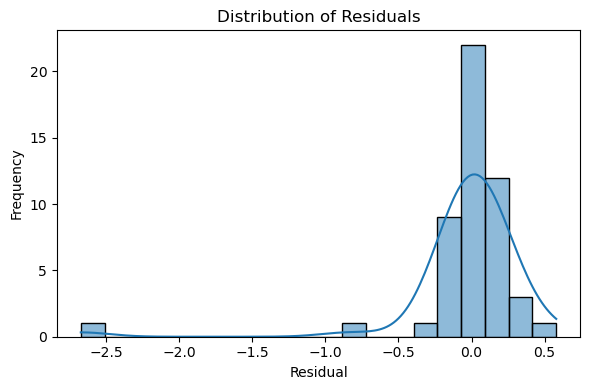

,lb_stat,lb_pvalue
10,7.762674,0.652006


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

# Calculate residuals
residuals = y_test_lagged - y_pred_lagged
residuals.index = y_test_lagged.index  # align index for time series analysis

# Plot residuals over time
plt.figure(figsize=(10, 4))
plt.plot(residuals, label="Residuals", marker='o')
plt.title("Residuals Over Time (Actual - Predicted UNRATE)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=20, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Ljung-Box test (autocorrelation of residuals)
ljung_box = acorr_ljungbox(residuals, lags=[10], return_df=True)

ljung_box


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Ensure data is sorted by time
df_lagged_sorted = df_lagged.sort_index()

# Split chronologically: 80% train, 20% test
split_index = int(len(df_lagged_sorted) * 0.8)
train_df = df_lagged_sorted.iloc[:split_index]
test_df = df_lagged_sorted.iloc[split_index:]

# Define features and target
X_train_chrono = train_df.drop(columns=['UNRATE'])
y_train_chrono = train_df['UNRATE']
X_test_chrono = test_df.drop(columns=['UNRATE'])
y_test_chrono = test_df['UNRATE']

# Train the model
rf_chrono = RandomForestRegressor(n_estimators=100, random_state=42)
rf_chrono.fit(X_train_chrono, y_train_chrono)

# Predict and evaluate
y_pred_chrono = rf_chrono.predict(X_test_chrono)
rmse_chrono = mean_squared_error(y_test_chrono, y_pred_chrono, squared=False)
r2_chrono = r2_score(y_test_chrono, y_pred_chrono)

# Collect results
rf_chrono_results = pd.DataFrame({
    'Actual_UNRATE': y_test_chrono,
    'Predicted_UNRATE': y_pred_chrono
}).reset_index(drop=True)

rmse_chrono, r2_chrono, rf_chrono_results.head()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(1.7467538178003221,
 0.4936494525839378,
    Actual_UNRATE  Predicted_UNRATE
 0            4.7             4.974
 1            4.7             4.845
 2            4.7             4.832
 3            4.6             4.825
 4            4.4             4.803)